In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [20]:
# Directory paths
train_dir = r'D:\CADT\CapstoneProjectI\ml__model\data\splited_data\train'
val_dir = r'D:\CADT\CapstoneProjectI\ml__model\data\splited_data\val'
test_dir = r'D:\CADT\CapstoneProjectI\ml__model\data\splited_data\test'

In [21]:
# Image dimensions
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 8246 images belonging to 9 classes.
Found 2362 images belonging to 9 classes.
Found 1182 images belonging to 9 classes.


In [27]:
# Print class indices to verify the number of classes
print("Class indices:", train_generator.class_indices)
num_classes = len(train_generator.class_indices)  # Should be 10 (9 diseases + 1 healthy)

class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        print(f"Epoch {epoch + 1}: Learning Rate: {lr:.6f}, Loss: {logs['loss']:.4f}, Accuracy: {logs['accuracy']:.4f}")


Class indices: {'Bacterial Leaf Blight': 0, 'Brown Spot': 1, 'Healthy Rice Leaf': 2, 'Leaf Blast': 3, 'Leaf scald': 4, 'Narrow Brown Leaf Spot': 5, 'Neck_Blast': 6, 'Rice Hispa': 7, 'Sheath Blight': 8}


In [28]:
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        print(f"Epoch {epoch + 1}: Learning Rate: {lr:.6f}, Loss: {logs['loss']:.4f}, Accuracy: {logs['accuracy']:.4f}")


In [29]:
# Build the MobileNetV3 model
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(9, activation='softmax')(x)  # 9 diseases + 1 healthy

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [30]:
# Callbacks
lr_logger = LearningRateLogger()
checkpoint_callback = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [31]:
# Training the model
history = model.fit(train_generator, 
                    validation_data=val_generator, 
                    epochs=10, 
                    callbacks=[lr_logger, checkpoint_callback, early_stopping_callback])

Epoch 1/10
516/516 [==============================] - 192s 366ms/step - loss: 2.2209 - accuracy: 0.1381 - val_loss: 2.1745 - val_accuracy: 0.1490
Epoch 2/10
516/516 [==============================] - 119s 230ms/step - loss: 2.1730 - accuracy: 0.1549 - val_loss: 2.1703 - val_accuracy: 0.1588
Epoch 3/10
516/516 [==============================] - 122s 237ms/step - loss: 2.1685 - accuracy: 0.1612 - val_loss: 2.1668 - val_accuracy: 0.1592
Epoch 4/10
516/516 [==============================] - 117s 227ms/step - loss: 2.1653 - accuracy: 0.1686 - val_loss: 2.1642 - val_accuracy: 0.1503
Epoch 5/10
516/516 [==============================] - 120s 233ms/step - loss: 2.1623 - accuracy: 0.1650 - val_loss: 2.1584 - val_accuracy: 0.1876
Epoch 6/10
516/516 [==============================] - 117s 228ms/step - loss: 2.1580 - accuracy: 0.1772 - val_loss: 2.1552 - val_accuracy: 0.1677
Epoch 7/10
516/516 [==============================] - 122s 236ms/step - loss: 2.1551 - accuracy: 0.1796 - val_loss: 2.1524 -

In [32]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

In [34]:
# Compile the model again with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [35]:
# Continue training the model
history_fine_tune = model.fit(train_generator, 
                               validation_data=val_generator, 
                               epochs=10, 
                               callbacks=[lr_logger, checkpoint_callback, early_stopping_callback])


Epoch 1/10
516/516 [==============================] - 117s 216ms/step - loss: 3.1357 - accuracy: 0.2102 - val_loss: 2.1987 - val_accuracy: 0.1401
Epoch 2/10
516/516 [==============================] - 122s 236ms/step - loss: 1.7646 - accuracy: 0.3819 - val_loss: 2.2845 - val_accuracy: 0.1351
Epoch 3/10
516/516 [==============================] - 118s 229ms/step - loss: 1.4693 - accuracy: 0.4931 - val_loss: 2.5472 - val_accuracy: 0.1088
Epoch 4/10
516/516 [==============================] - 119s 231ms/step - loss: 1.2579 - accuracy: 0.5726 - val_loss: 2.8771 - val_accuracy: 0.0931
Epoch 5/10
516/516 [==============================] - 113s 218ms/step - loss: 1.0761 - accuracy: 0.6392 - val_loss: 3.0388 - val_accuracy: 0.0906
Epoch 6/10
516/516 [==============================] - 109s 211ms/step - loss: 0.9353 - accuracy: 0.6847 - val_loss: 3.1497 - val_accuracy: 0.0940


In [36]:
# Save the final model
model.save('D:\CADT\CapstoneProjectI\ml__model\models\mobilenetV3.h5')

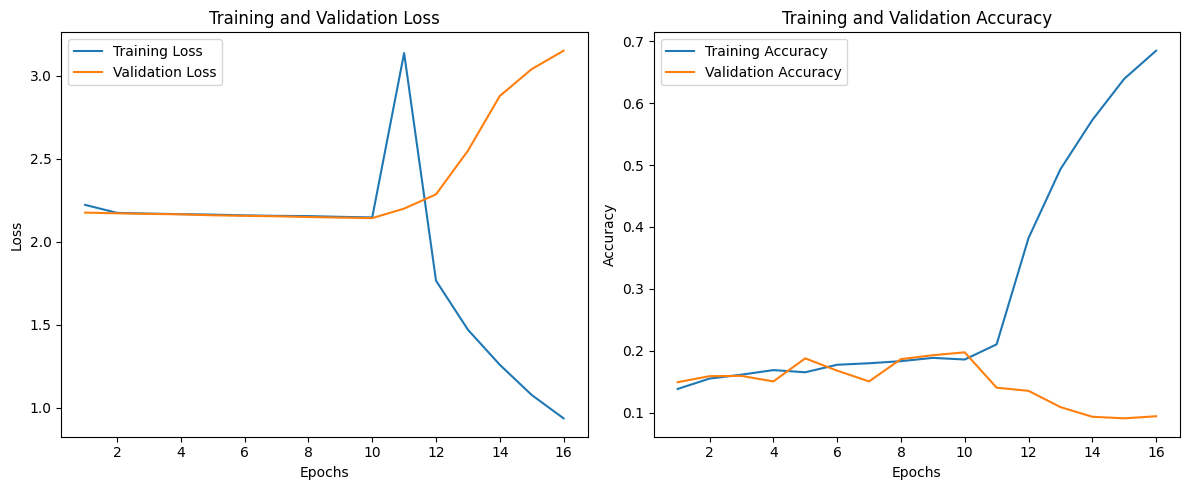

74/74 [==============================] - 15s 209ms/step - loss: 2.1970 - accuracy: 0.1413
Test Loss: 2.1970, Test Accuracy: 0.1413
74/74 [==============================] - 8s 98ms/step
Classification Report:
                        precision    recall  f1-score   support

 Bacterial Leaf Blight       0.00      0.00      0.00       120
            Brown Spot       0.00      0.00      0.00       155
     Healthy Rice Leaf       0.00      0.00      0.00       109
            Leaf Blast       0.00      0.00      0.00       175
            Leaf scald       0.00      0.00      0.00       134
Narrow Brown Leaf Spot       0.00      0.00      0.00        96
            Neck_Blast       0.00      0.00      0.00       100
            Rice Hispa       0.00      0.00      0.00       130
         Sheath Blight       0.14      0.99      0.24       163

              accuracy                           0.14      1182
             macro avg       0.02      0.11      0.03      1182
          weighted avg

C:\Users\Hak Sou\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hak Sou\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hak Sou\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

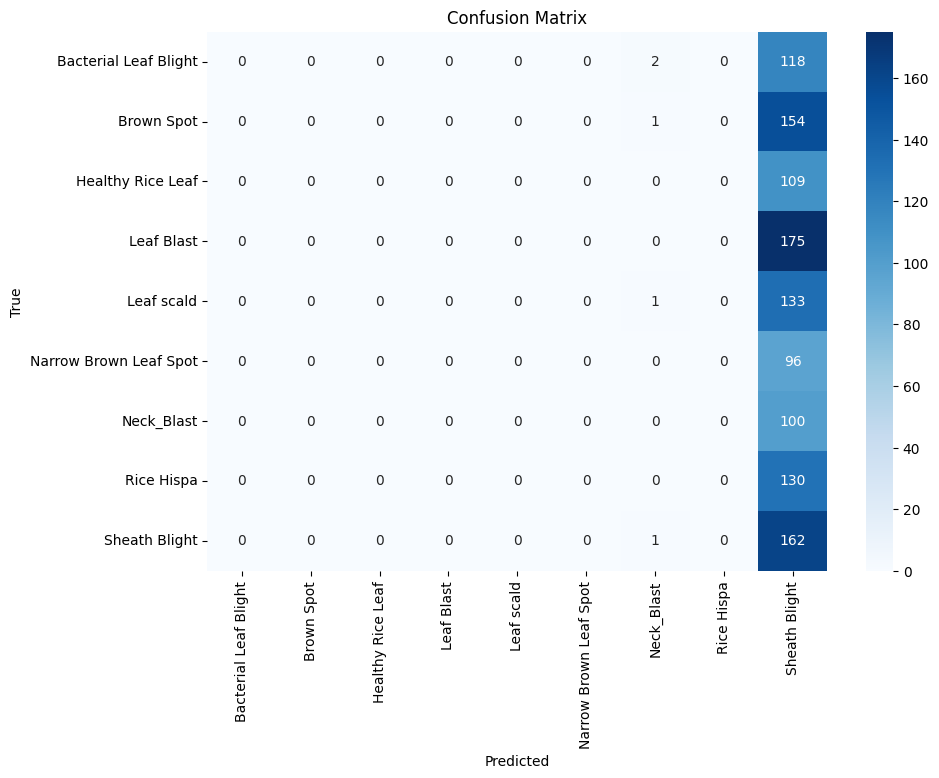

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Assuming 'history' and 'history_fine_tune' are already defined from the model training

# 1. Plot training and validation loss and accuracy
def plot_training_history(history, history_fine_tune):
    # Combine histories
    loss = history.history['loss'] + history_fine_tune.history['loss']
    val_loss = history.history['val_loss'] + history_fine_tune.history['val_loss']
    accuracy = history.history['accuracy'] + history_fine_tune.history['accuracy']
    val_accuracy = history.history['val_accuracy'] + history_fine_tune.history['val_accuracy']
    
    epochs = range(1, len(loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot history
plot_training_history(history, history_fine_tune)

# 2. Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# 3. Generate predictions from the test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# 4. Classification Report
target_names = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# 5. Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plotting Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Found 1182 images belonging to 9 classes.
37/37 [==============================] - 6s 177ms/step


<Figure size 1000x800 with 0 Axes>

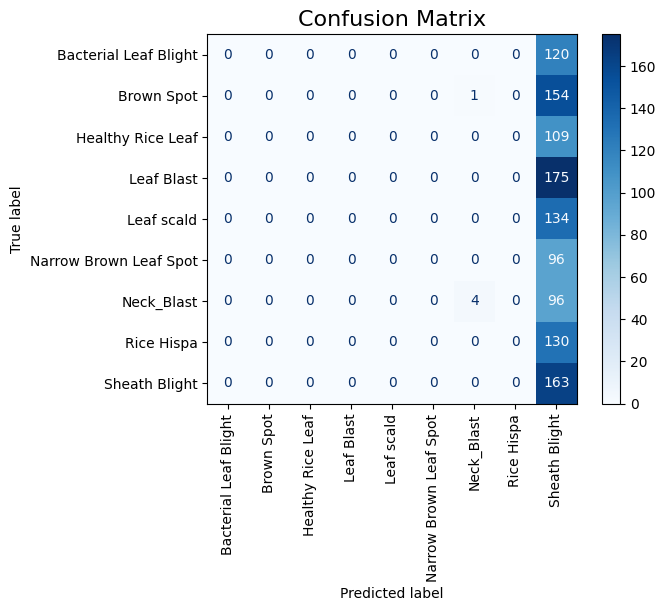

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the test data
test_dir = r'D:\CADT\CapstoneProjectI\ml__model\data\splited_data\test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for correct label ordering
)

# Get true labels from the 'test_ds' directory iterator
true_labels = test_ds.classes  # True labels

# Assuming 'model' is already trained
pred_probs = model.predict(test_ds)
pred_labels = np.argmax(pred_probs, axis=1)  # Convert probabilities to class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Display the confusion matrix
class_labels = list(test_ds.class_indices.keys())  # Get class labels from the generator
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

plt.title('Confusion Matrix', fontsize=16)
plt.show()

Found 1182 images belonging to 9 classes.
37/37 [==============================] - 7s 181ms/step


C:\Users\Hak Sou\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hak Sou\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Hak Sou\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

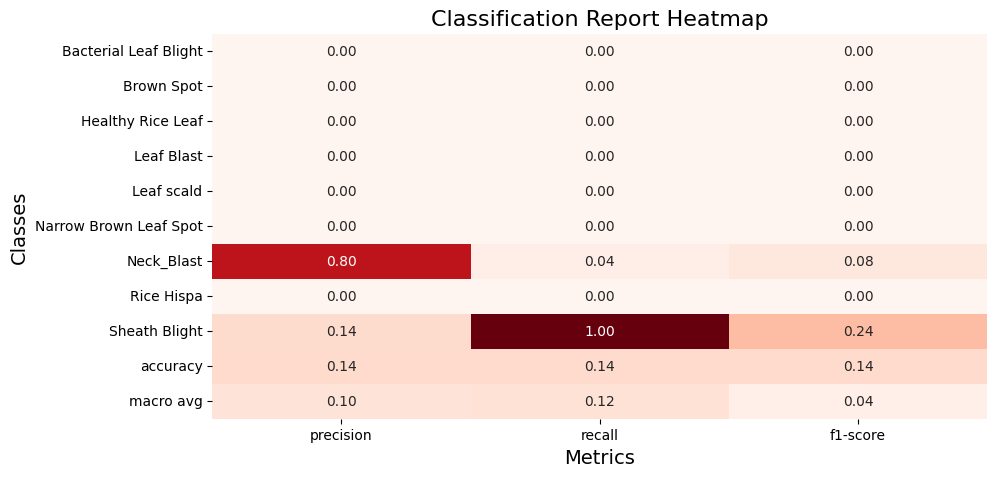

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the test data
test_dir = r'D:\CADT\CapstoneProjectI\ml__model\data\splited_data\test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_ds = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important for correct label ordering
)

# Get true labels from the 'test_ds' directory iterator
true_labels = test_ds.classes  # True labels

# Assuming 'model' is already trained
pred_probs = model.predict(test_ds)
pred_labels = np.argmax(pred_probs, axis=1)  # Convert probabilities to class labels

# Generate a classification report
report = classification_report(true_labels, pred_labels, target_names=list(test_ds.class_indices.keys()), output_dict=True)

# Convert the report to a DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Plot the heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap=plt.cm.Reds, fmt=".2f", cbar=False)
plt.title('Classification Report Heatmap', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Classes', fontsize=14)
plt.show()